In [1]:
import os # os functionalities
import random # generation of random numbers
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O
from sklearn import metrics # create ROC curve
from matplotlib import pyplot as plt # image visualization

# Tensorflow & Keras
import warnings
import tensorflow as tf
from tensorflow import keras
import tensorflow_addons as tfa
warnings.filterwarnings('ignore')
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img

# Image manipulation
from skimage import io
from PIL import Image, ImageOps
from IPython.display import Image, display

C:\Users\arunm\AppData\Roaming\Python\Python39\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
C:\Users\arunm\AppData\Roaming\Python\Python39\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file a

In [2]:
# Variable declaration
input_dir = r"C:\Users\arunm\thusharproj\test\finaldataset\images"
target_dir = r"C:\Users\arunm\thusharproj\test\finaldataset\lables"

epochs = 20
batch_size = 16
img_size = (160,160)
learning_rate = 0.001
optimizer = "RMSprop"
data_augmentation = False
loss_function = "sparse_categorical_crossentropy"
num_classes = 2 # 0 - 1 / lesion - no lesion

# Percentages of images going to train - val - test sets
percentage_test = 0.05
percentage_validation = 0.12

In [3]:
input_dir

'C:\\Users\\arunm\\thusharproj\\test\\finaldataset\\images'

In [4]:
# Get paths to the training and target images
input_img_paths = sorted([
    os.path.join(input_dir, fname)
    for fname in os.listdir(input_dir)
    if fname.endswith(".jpg")])

target_img_paths = sorted([
    os.path.join(target_dir, fname)
    for fname in os.listdir(target_dir)
    if fname.endswith(".png") and not fname.startswith(".")])

# Check if dimentions are equal
print("Number of samples in the training set:", len(input_img_paths))
print("Number of samples in the target set:", len(target_img_paths))

Number of samples in the training set: 2010
Number of samples in the target set: 2010


The shape of the pictures in the training set is: (1939, 3048, 3)
The shape of the pictures in the target set is: (1939, 3048)


Text(0.5, 1.0, 'Segmentation mask')

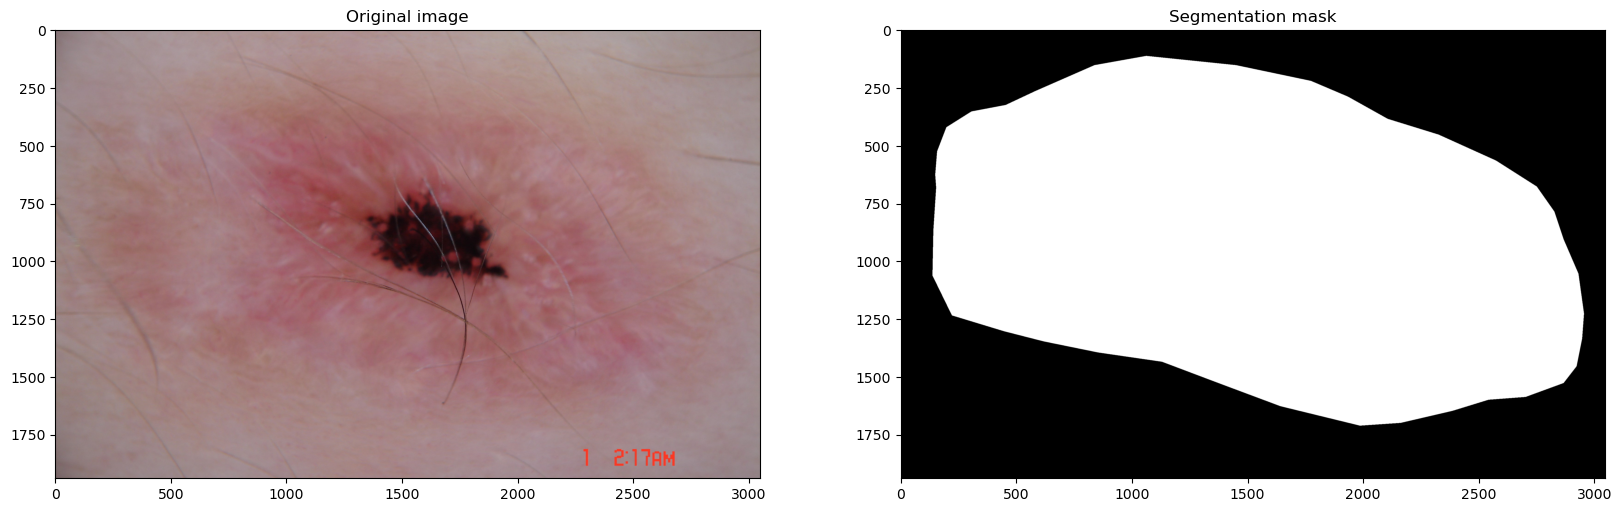

In [5]:
# Read training images and get their shape
image_to_visualize = 500
img1 = io.imread(input_img_paths[image_to_visualize])
img_shape = np.shape(img1)
print(f"The shape of the pictures in the training set is: {img_shape}")

# Read target images and get their shape
img1 = io.imread(target_img_paths[image_to_visualize])
img_shape = np.shape(img1)
print(f"The shape of the pictures in the target set is: {img_shape}")

# Create figure
fig = plt.figure(figsize=(20, 20))

# Cetting values to rows and column variables
rows = 1
columns = 2

# Plot images - Visualize an image and it's segmentation
fig.add_subplot(rows, columns, 1)
plt.imshow(io.imread(input_img_paths[image_to_visualize]))
plt.title("Original image")

fig.add_subplot(rows, columns, 2)
plt.imshow(io.imread(target_img_paths[image_to_visualize]), cmap='gray')
plt.title("Segmentation mask")

In [6]:
class LesionSegmentation(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths, data_augmentation):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths
        self.data_augmentation = data_augmentation

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
    
        
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        
        if self.data_augmentation:
            x = np.zeros((self.batch_size * 2,) + self.img_size + (3,), dtype="float32")
            y = np.zeros((self.batch_size * 2,) + self.img_size + (1,), dtype="uint8")
            
            for j, path in enumerate(batch_input_img_paths):
                img = load_img(path, target_size=self.img_size)
                img_target = load_img(batch_target_img_paths[j], target_size=self.img_size, color_mode="grayscale")
                img_target2 = load_img(batch_target_img_paths[j], target_size=self.img_size)
                
                # Convert PIL Images to NumPy arrays
                img_array = np.array(img)
                img_target_array = np.array(img_target)
                img_target2_array = np.array(img_target2)
                
                # Apply data augmentation
                img_augmented, img_target_augmented = self.generate_data_augmentation(img_array, img_target2_array)
                
                # Normalize and assign images
                x[j] = tf.cast(img_array, tf.float32) / 255.0
                y[j] = (np.expand_dims(img_target_array, 2) / 255).astype(int)
                x[self.batch_size + j] = tf.cast(img_augmented, tf.float32) / 255.0
                
                # Convert augmented target to grayscale if necessary and assign
                img_target_augmented = tf.image.rgb_to_grayscale(img_target_augmented)
                y[self.batch_size + j] = (img_target_augmented.numpy() / 255).astype(int)
        
        else:
            x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
            y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
            
            for j, path in enumerate(batch_input_img_paths):
                img = load_img(path, target_size=self.img_size)
                img_target = load_img(batch_target_img_paths[j], target_size=self.img_size, color_mode="grayscale")
                
                # Convert PIL Images to NumPy arrays
                img_array = np.array(img)
                img_target_array = np.array(img_target)
                
                # Normalize and assign images
                x[j] = tf.cast(img_array, tf.float32) / 255.0
                y[j] = (np.expand_dims(img_target_array, 2) / 255).astype(int)
        
        return x, y

    
    
    def generate_data_augmentation(self, img_orig, mask_orig):
        """Custom data augmentation function whose purpose is to generate new images by modifying the images already 
        present in the dataset. The fact that the function is custom respons to the imposibility of finding an adequate
        utility in Tensorflow for this pupose that is able to modify both the images and the segmentations in the same way."""
        
        # Zoom
        if tf.random.uniform(()) > 0.5:
            img_orig = tf.image.central_crop(img_orig, 0.75)
            mask_orig = tf.image.central_crop(mask_orig, 0.75)
            img_orig = tf.image.resize(img_orig, self.img_size)
            mask_orig = tf.image.resize(mask_orig, self.img_size)

        # Random brightness adjustment illumination
        img_orig = tf.image.random_brightness(img_orig, 0.3)
        
        # Random contrast adjustment
        img_orig = tf.image.random_contrast(img_orig, 0.2, 0.5)

        # Flipping random horizontal or vertical
        if tf.random.uniform(()) > 0.5:
            img_orig = tf.image.flip_left_right(img_orig)
            input_mask = tf.image.flip_left_right(mask_orig)
        if tf.random.uniform(()) > 0.5:
            img_orig = tf.image.flip_up_down(img_orig)
            input_mask = tf.image.flip_up_down(mask_orig)

        # Rotation in 30° steps
        rot_factor = tf.cast(tf.random.uniform(shape=[], maxval=12, dtype=tf.int32), tf.float32)
        angle = np.pi/12*rot_factor
        img_orig = tfa.image.rotate(img_orig, angle)
        mask_orig = tfa.image.rotate(mask_orig, angle)
        
        return img_orig, mask_orig

In [7]:
# Split our img paths into a training validation and test sets
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)

test_samples = int(len(input_img_paths)*percentage_test)
train_input_img_paths = input_img_paths[:-test_samples]
train_target_img_paths = target_img_paths[:-test_samples]
test_input_img_paths = input_img_paths[-test_samples:]
test_target_img_paths = target_img_paths[-test_samples:]

val_samples = int(len(train_input_img_paths)*percentage_validation)
val_input_img_paths = train_input_img_paths[-val_samples:]
val_target_img_paths = train_target_img_paths[-val_samples:]
train_input_img_paths = train_input_img_paths[:-val_samples]
train_target_img_paths = train_target_img_paths[:-val_samples]

print(f"Samples in train: {len(train_input_img_paths)}")
print(f"Samples in validation: {len(val_input_img_paths)}")
print(f"Samples in test: {len(test_input_img_paths)}")

Samples in train: 1681
Samples in validation: 229
Samples in test: 100


In [8]:
# Instantiate data Sequences for each split
train_gen = LesionSegmentation(batch_size, img_size, train_input_img_paths, train_target_img_paths, data_augmentation)
val_gen = LesionSegmentation(batch_size, img_size, val_input_img_paths, val_target_img_paths, False)

In [9]:
def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))
    
    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    
    return model

# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model(img_size, num_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 80, 80, 32)   896         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 80, 80, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [10]:
# Choose optimizer
if optimizer == "SGD": # SGD
    fit_optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9, decay=learning_rate/epochs)
elif optimizer == "RMSprop": # RMSprop
    fit_optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate, decay=learning_rate/epochs)
else:  # Adam
    fit_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=1e-8, amsgrad=True)

In [11]:
# Configure the model for training
model.compile(optimizer=fit_optimizer, loss=loss_function)

# Save the best model during training
callbacks = [keras.callbacks.ModelCheckpoint("final_lesion_segmentation.h5", save_best_only=True)]

# Train the model, doing validation at the end of each epoch
model_history = model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

# Serialize and save the model architecture to JSON
model2_json = model.to_json()
with open("final_model.json", "w") as json_file:
    json_file.write(model2_json)

# Serialize and save the model weights to HDF5
model.save_weights("final_model.h5")
print("Saved model to disk")


Epoch 1/20
105/105 [==============================] - 203s 2s/step - loss: 0.6898 - val_loss: 0.8384
Epoch 2/20
105/105 [==============================] - 169s 2s/step - loss: 0.2817 - val_loss: 0.9652
Epoch 3/20
105/105 [==============================] - 178s 2s/step - loss: 0.2272 - val_loss: 0.6051
Epoch 4/20
105/105 [==============================] - 174s 2s/step - loss: 0.1928 - val_loss: 0.3776
Epoch 5/20
105/105 [==============================] - 167s 2s/step - loss: 0.1766 - val_loss: 0.1819
Epoch 6/20
105/105 [==============================] - 157s 1s/step - loss: 0.1619 - val_loss: 0.1467
Epoch 7/20
105/105 [==============================] - 158s 2s/step - loss: 0.1482 - val_loss: 0.1407
Epoch 8/20
105/105 [==============================] - 160s 2s/step - loss: 0.1410 - val_loss: 0.1365
Epoch 9/20
105/105 [==============================] - 161s 2s/step - loss: 0.1296 - val_loss: 0.1700
Epoch 10/20
105/105 [==============================] - 162s 2s/step - loss: 0.1202 - val_lo

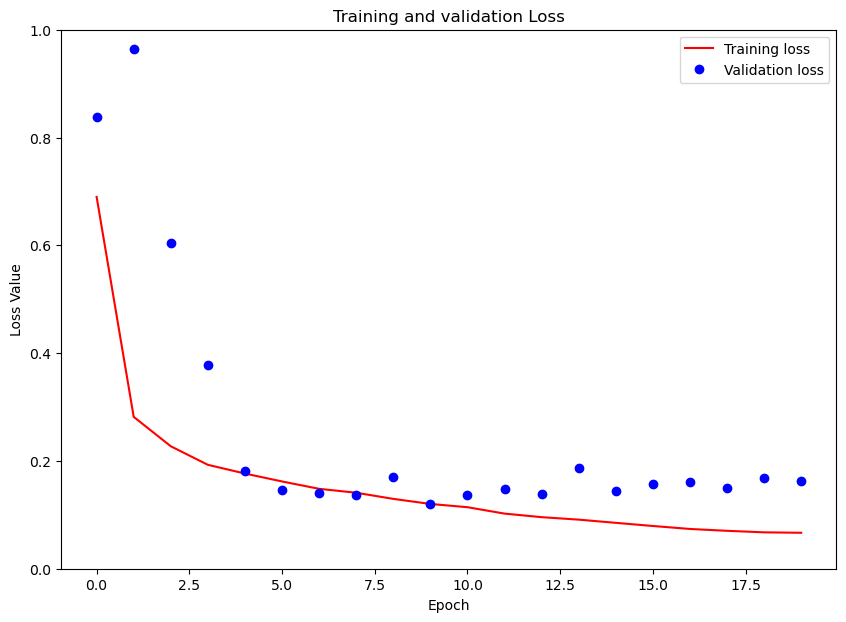

In [12]:
# Plot training and validation loss while training
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure(figsize=(10, 7))
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.savefig('Training and validation loss.jpg', dpi=500)
plt.show()

In [13]:
test_gen = LesionSegmentation(batch_size, img_size, test_input_img_paths, test_target_img_paths, False)
test_preds = model.predict(test_gen)

jaccard_scores = []
dice_scores = []
pixel_accuracy = []
sensitivity = []
specitivity = []
 
predictions_formatted = []
ground_truth_formatted = []
    
for i in range(0, len(test_preds)):
    # Adapt prediction and ground truth
    prediction = np.argmax(test_preds[i], axis=-1)
    prediction = np.expand_dims(prediction, axis=-1)
    predictions_formatted.append(prediction.flatten())
    ground_truth = np.array(load_img(test_target_img_paths[i], target_size=img_size, color_mode="grayscale"))
    ground_truth = (np.expand_dims(ground_truth, 2)/255).astype(int)
    ground_truth_formatted.append(ground_truth.flatten())
    number_of_pixels = img_size[0]*img_size[1]    
    
    # Get Jaccard score
    intersection = np.logical_and(ground_truth, prediction)
    union = np.logical_or(ground_truth, prediction)
    jaccard_scores.append(np.sum(intersection) / np.sum(union))  
    
    # Get Dice coefficient
    intersection = np.sum(ground_truth.flatten() == prediction.flatten())
    dice_scores.append((2 * np.sum(intersection) ) / (number_of_pixels + number_of_pixels))
    
    # Pixel-based metrics
    equal_pixels = 0
    number_of_true_positives = 0
    number_of_true_negatives = 0
    number_of_false_negatives = 0
    number_of_false_positives = 0
    
    for row in range(len(ground_truth)):
        for column in range(len(ground_truth[row])):
            
            if prediction[row][column] == ground_truth[row][column]:
                equal_pixels += 1
                
            if ground_truth[row][column] == 1 and prediction[row][column] == ground_truth[row][column]:
                number_of_true_positives += 1
                
            if ground_truth[row][column] == 0 and prediction[row][column] == ground_truth[row][column]:
                number_of_true_negatives +=1
            
            if prediction[row][column] == 1 and prediction[row][column] != ground_truth[row][column]:
                number_of_false_positives += 1
            
            if prediction[row][column] == 0 and prediction[row][column] != ground_truth[row][column]:
                number_of_false_negatives += 1
                
    # Pixel accuracy: (Correct predictions / Number of predictions)      
    pixel_accuracy.append(equal_pixels / number_of_pixels)
    # Sensitivity - Recall: True positive rate (True positives / True positives + False negatives). How many of the positives are correct
    try:sensitivity.append(number_of_true_positives / (number_of_true_positives + number_of_false_negatives))
    except:sensitivity.append(0)
    # Specitivity - True negative rate (True negative / True negative + False positives). How many of the negatives are correct
    try: specitivity.append(number_of_true_negatives / (number_of_true_negatives + number_of_false_positives))
    except: specitivity.append(0)
        
print(f"Jaccard Score: {np.mean(jaccard_scores)} \nDice Score: {np.mean(dice_scores)} \nPixel accuracy: {np.mean(pixel_accuracy)} \nSensitivity: {np.mean(sensitivity)} \nSpecificity: {np.mean(specitivity)}")

6/6 [==============================] - 6s 941ms/step
Jaccard Score: nan 
Dice Score: 0.9447298177083333 
Pixel accuracy: 0.9447298177083333 
Sensitivity: 0.8537635029455982 
Specificity: 0.9702767416194904


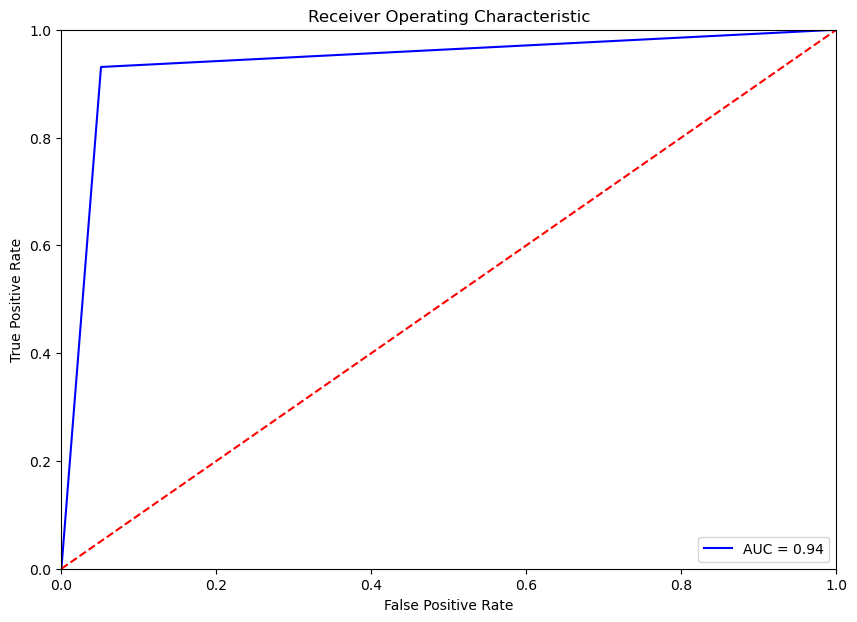

In [14]:
# Get and plot ROC curve
fpr, tpr, threshold = metrics.roc_curve(np.array(predictions_formatted).flatten(), np.array(ground_truth_formatted).flatten())
roc_auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(10, 7))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('ROC_curve.jpg', dpi=500)
plt.show()

In [19]:
def adapt_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(test_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    return img

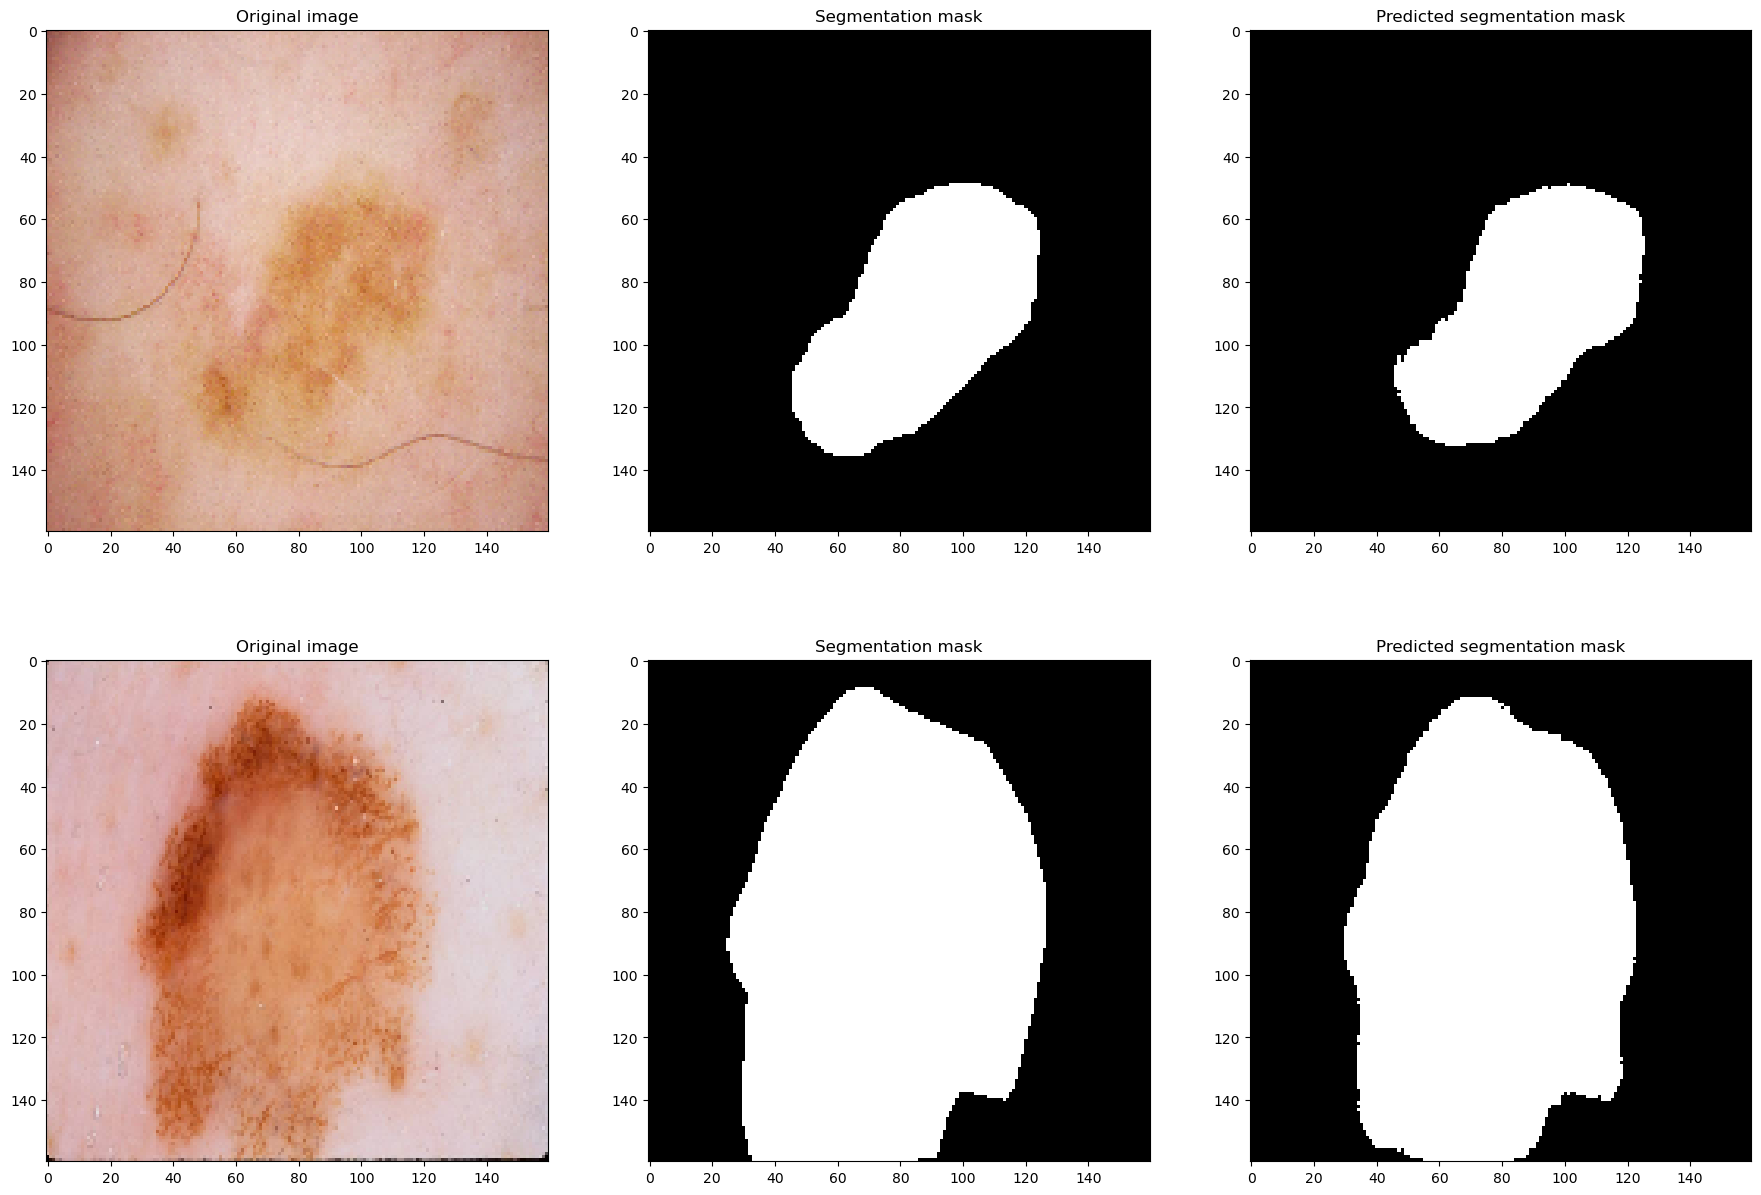

In [20]:
# Cetting values to rows and column variables
rows = 2
columns = 3

# Create figure
fig, axs = plt.subplots(nrows=rows, ncols=columns, figsize=(22, 15))
row = 0

for i in [1, 7]:
    
    column = 0
    
    # Plot images
    axs[row, column].imshow(load_img(test_input_img_paths[i], target_size=img_size))
    axs[row, column].set_title("Original image")
    column+=1
    
    axs[row, column].imshow(load_img(test_target_img_paths[i],  target_size=img_size), cmap='gray')
    axs[row, column].set_title("Segmentation mask")
    column+=1
    
    axs[row, column].imshow(adapt_mask(i), cmap='gray')
    axs[row, column].set_title("Predicted segmentation mask")
    column+=1
    row+=1

plt.savefig('Predicted segmantation masks.jpg', dpi=300)

In [17]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
# Flatten predictions and ground truth for evaluation
flat_predictions = np.array(predictions_formatted).flatten()
flat_ground_truth = np.array(ground_truth_formatted).flatten()

# Generate the classification report
report = classification_report(flat_ground_truth, flat_predictions, target_names=['No Lesion', 'Lesion'])
print("Classification Report:\n", report)

# You can also generate a confusion matrix
conf_matrix = confusion_matrix(flat_ground_truth, flat_predictions)
print("Confusion Matrix:\n", conf_matrix)

Classification Report:
               precision    recall  f1-score   support

   No Lesion       0.95      0.98      0.96   1831904
      Lesion       0.93      0.85      0.89    625696

    accuracy                           0.94   2457600
   macro avg       0.94      0.91      0.92   2457600
weighted avg       0.94      0.94      0.94   2457600

Confusion Matrix:
 [[1792626   39278]
 [  96554  529142]]
